In [7]:
import torchvision
import random
from tools.data_utils import gen_pins, gen_mesh_pins, count_pins, save_data
from tools.plot_utils import visualize_pins, plot_label_pin
import os
import matplotlib.pyplot as plt

In [3]:
def PinMNIST(n, n_pin_max, r, fixed_pins=True, mesh=False, d=1):
    """
    Generate PinMNIST dataset by selecting n unique samples from the original MNIST and adding pins.

    Args:
    n (int): Number of unique samples to select from the original MNIST.
    n_pin_max (int): Maximum number of pins to generate for each sample.
    r (int): Radius for counting adjacent ones around each pin.
    fixed_pins (bool): If True, generates a fixed number of pins (n_pin_max) for all samples. If False, generates a random number of pins for each sample.
    mesh (bool): If True, generates pins on a mesh grid based on the 'd' parameter.
    d (int): Spacing between pins when 'mesh' is True.

    Returns:
    images (list): List of binary images.
    pins (list): List of lists of (x, y) coordinate tuples.
    count_images (list): List of count images where counts are the counted values at the pin locations.
    """
    # Load the original MNIST dataset
    original_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True)

    # Shuffle the original MNIST dataset
    random.shuffle(original_mnist.data)

    # Initialize lists to store images, pins, and count images
    images = []
    pins = []
    labels = []

    for i in range(n):
        # Get the binary image from the shuffled MNIST dataset
        mnist_image = original_mnist.data[i] / 255.0  # Normalize to [0, 1]

        # Determine the number of pins to generate
        if mesh:
            pin_locations = gen_mesh_pins(mnist_image, d)
        else:
            if fixed_pins:
                n_pins = n_pin_max
            else:
                n_pins = random.randint(1, n_pin_max)
            # Generate random pins for the binary image
            pin_locations = gen_pins(mnist_image, n_pins)

        # Count the adjacent ones for the pins using the count_pins function
        label = count_pins(mnist_image.numpy(), pin_locations, r)

        images.append(mnist_image)
        pins.append(pin_locations)
        labels.append(label)

    return images, pins, labels

In [4]:
n=100
n_pin_max = 50
fixed_pins = True
mesh = True
d = 5
r = 3

images, pins, labels = PinMNIST(n, n_pin_max, r, mesh=mesh, d=d)

In [5]:
output_directory = f'./data/MNIST_{n}images_mesh{mesh, d}_{n_pin_max}pins_fixedpins{fixed_pins}_radius{r}/'
os.makedirs(output_directory, exist_ok=True)  
save_data(images, pins, labels, output_directory)

Data and images have been saved to the CSV and image files.


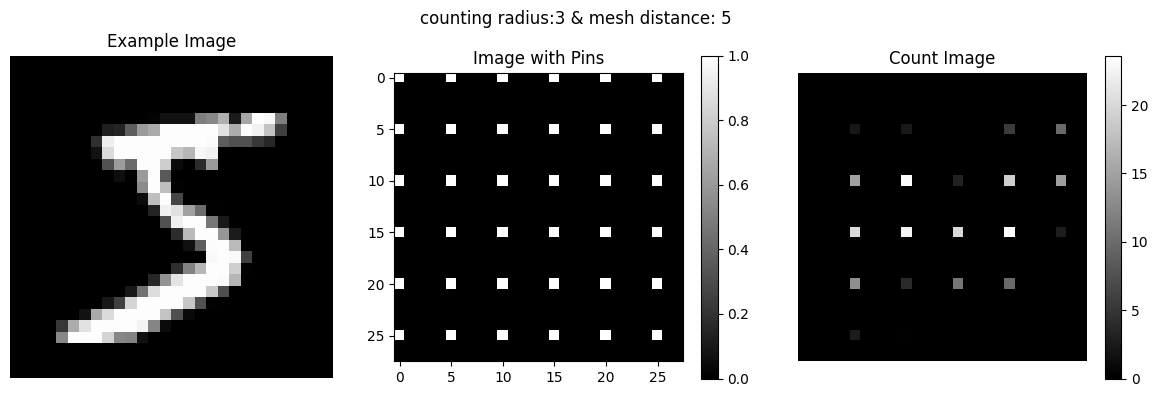

In [8]:
example_image, example_pin, example_label = images[0], pins[0], labels[0]

# Create a subplot with three columns
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Display the original binary image (example_image) in the first column
axes[0].imshow(example_image, cmap='gray')
axes[0].set_title("Example Image")
axes[0].axis('off')

# Display the image with pins and color mapping in the second column
pins_image = visualize_pins(example_image, example_pin)
axes[1].imshow(pins_image, cmap='gray')
cbar1 = plt.colorbar(axes[1].images[0], ax=axes[1])  # Add colorbar to axes[1]
axes[1].set_title("Image with Pins")

# Display the count image (count_image) in the third column
count_image = plot_label_pin(example_image, example_pin, example_label)
im = axes[2].imshow(count_image, cmap='gray')
cbar2 = plt.colorbar(im, ax=axes[2])  # Add colorbar to axes[2]
axes[2].set_title("Count Image")
axes[2].axis('off')

plt.suptitle(f"counting radius:{r} & mesh distance: {d}")
plt.tight_layout()
plt.show()